In [1]:
import h5py
import numpy as np
import scipy.ndimage
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

import matplotlib.pyplot as plt

# Load in data

In [2]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
tf_filename = "../lya_fields/results/tf_fields1x1x1024.h5"

h5 = h5py.File(filename,'r')
tf_h5 = h5py.File(tf_filename,'r')

# full fields
DM_dens = h5['native_fields']['matter_density'][()] # rho
baryon_dens = h5['native_fields']['baryon_density'][()] # rho_b
temperature = h5['native_fields']['temperature'][()] # T

treal = tf_h5['tau_real'][()] # real-space optical depth (lya-tf)
treal_g = h5['derived_fields']['tau_real'][()] # real-space optical depth (Gimlet)

h5.close()
tf_h5.close()

# Fit the DM-to-baryon formulas

Let $\rho$ be the ratio of dark matter density to the mean DM density, and let $\rho_b$ be the same for baryons. Let $\sigma_T$ and $\sigma_\rho$ be the smoothing scales for temperature and baryon density, respectively.

Baryon temperature:
$$T = T_0 [\text{gaussian_smoothing}(\rho, \sigma_T)]^{\gamma_T-1} $$
Baryon density:
$$\rho_b = \rho_{b,0} [\text{gaussian_smoothing}(\rho, \sigma_\rho)]^{\gamma_\rho-1} $$

In [3]:
type(DM_dens)

numpy.ndarray

In [4]:
# train on one part of the snapshot
train_inds = (512,
              slice(0, 1024),
              slice(0, 1024))
rho_train = DM_dens[train_inds]
rhob_train = baryon_dens[train_inds]
temp_train = temperature[train_inds]

# test on one skewer
test_inds = (0, 0, slice(0, 1024))
rho_test = DM_dens[test_inds]
rhob_test = baryon_dens[test_inds]
temp_test = temperature[test_inds]

In [29]:
def obj_fn(params, x):
    '''
    The objective function to be minimized for fitting x = x0 * [gaussian_smoothing(rho, sigma)]^(gamma-1),
    where x is either T or rho_b.
    
    PARAMETERS
    ----------
    params: a tuple containing (x0, sigma, gamma)
    x: a string, either 'rho' (for baryon density) or 't' (for temperature)
    
    '''
    
    x0, sigma, gamma = params
    
    x_pred = x0 * (scipy.ndimage.gaussian_filter(rho_train, sigma))**(gamma - 1)
    
    if x == 'rho':
        return np.mean(np.square(rhob_train - x_pred))
    elif x == 't':
        return np.mean(np.square(temp_train - x_pred))
    else:
        raise ValueError("Invalid argument: x must be either 'rho' or 't'")

## Attempt 1 (scipy.optimize.minimize, doesn't work)

This doesn't optimize at all; it runs 0 iterations and ends with a Jacobian of `array([0., 0., 0.])`. I suspect it's because gaussian_filter doesn't have a built-in gradient.

In [12]:
guess = (np.mean(rhob_train), np.std(rhob_train), 1.6)
options = {'maxiter': 10, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('rho')), options = options)

In [23]:
result

      fun: 20.845213
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.        , 4.49901867, 1.5       ])

## Attempt 2 (trial and error)

In [30]:
guess = (np.mean(rhob_train), np.std(rhob_train), 1.6)
guess

(0.7772019, 4.4990187, 1.6)

In [63]:
def obj_fn_vec(x0, sigma, gamma=1.6, x='rho'):
    '''
    A vectorized version of obj_fn.
    
    PARAMETERS
    ----------
    x0, sigma, gamma: the parameters to be fitted
    x: a string, either 'rho' (for baryon density) or 't' (for temperature)
    
    '''
    
    params = (x0, sigma, gamma)
    return obj_fn(params, x)

obj_fn_vec(0.8, 4.5, 2, 'rho')

4.438488

adjusting x0 and sigma

https://stackoverflow.com/questions/61107875/how-to-pass-meshgrid-as-an-argument-to-a-function-which-only-allows-an-array-in

In [85]:
x0 = np.linspace(0.5, 1, 20)
sigma = np.linspace(3, 7, 20)

X0, Sigma = np.meshgrid(x0, sigma)#, sparse=True)

result = map(lambda params: obj_fn_vec(params[0], params[1]), zip(X0.flatten(), Sigma.flatten()))

In [86]:
losses = np.fromiter(result, dtype=np.float)
losses.shape

(400,)

In [91]:
losses = np.reshape(losses, (20,20))
losses[0,19]

15.180481910705566

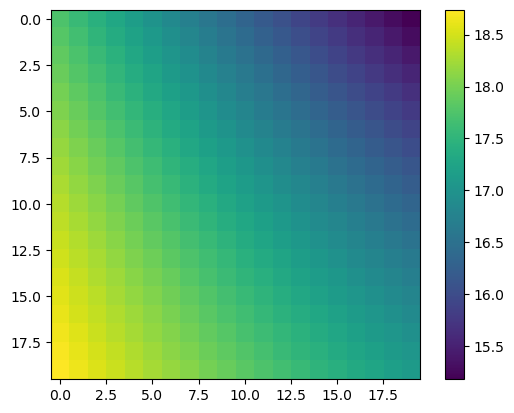

In [90]:
plt.imshow(losses)
plt.colorbar()
plt.show()

adjusting gamma

In [48]:
gammas = np.linspace(1.8, 2.2, 10)
losses = np.empty_like(gammas)

for i in range(len(gammas)):
    losses[i] = obj_fn((0.8, 4.5, gammas[i]), 'rho')

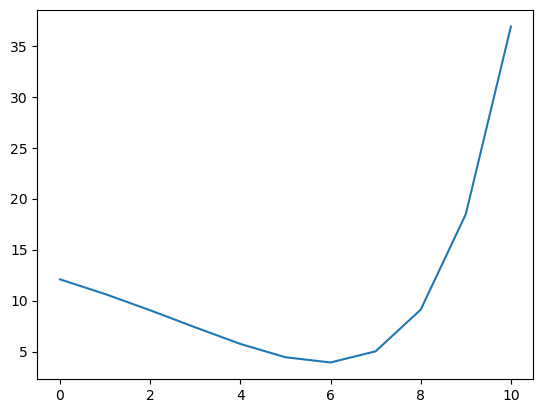

In [49]:
plt.plot(losses)
plt.show()

## Plot fitting results

/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


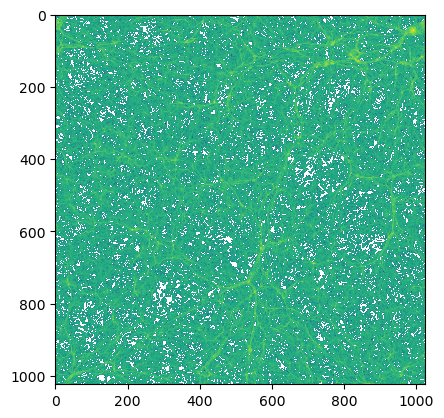

In [28]:
plt.imshow(np.log(rho_train))
plt.show()

# Perform optimization

When we feed the input $\rho$ into the model, it returns the output $\tau_{real}$.

In [ ]:
# take a skewer
shape = [1, 1, 1024]
inds = (0, 0, slice(0, shape[2]))
rho_true = DM_dens[inds]
treal_true = treal[inds]

# create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal([shape[2]], 0, 0.5, tf.float32, seed=1)
rho_pred = tf.Variable(10**log10_noise)

# define eos object
# ...

# define the model
def model(rho_pred):
    # get rho and T skewers from analytical formulas
    # ...
    
    # get n via eos object
    # ...
    
    # get treal via something like lya_fields.py
    treal_pred = # ...
    
    return treal_pred
    
# loss function
mse = keras.losses.MeanSquaredError()
loss_fn = lambda: mse(model(rho_pred), y_true)

# optimizer
optim = tf.optimizers.Adam(learning_rate=0.1)
#optim = keras.optimizers.SGD(learning_rate=1e3)

print('Initial loss:', mse(model(rho_pred), treal_true).numpy())

losses = tfp.math.minimize(loss_fn,
                           num_steps=10,
                           optimizer=optim)

print('Final loss:', losses[-1].numpy())
treal_pred_final = model(rho_pred) # final prediction for tau_real

In [ ]:
# TODO: replicate results with Gimlet's tau_real
# ...

# Plot reconstruction results

In [ ]:
# true and predicted log(input)
plt.figure(figsize=(10,4))

plt.plot(np.log10(rho_true), color='black', label='log10(rho) (true)')
plt.plot(np.log10(rho_pred), 'blue', label = 'log10(rho) (pred)', alpha=0.5)
plt.title('log10(rho)')
plt.ylim(-5, 3)
plt.legend()
plt.show()

# true and predicted "data"
plt.figure(figsize=(10,4))
plt.plot(treal_true, color='black', label='tau_real (true)')
plt.plot(treal_pred_final, 'blue', label = 'tau_real (pred)', alpha=0.5)
plt.title('tau_real')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(10,4))
plt.plot(np.log10(losses))
plt.title('log10(loss)')
plt.show()